# Курсовая работа.
## GeekBrains.
# Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn.
## Виталий Казанцев.

Требования к курсовому проекту:

Нужно будет оформить ноутбук с основными этапами:
1. подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. обучение модели
3. проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда (https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528): (вкладка data)


________________________
За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline


Что обязательно стоит попробовать:

1. Тщательный анализ данных
2. Поиск странных значений
3. Предобработка данных
4. Генерация разнообразных признаков
5. Разные модели и их разные гиперпараметры

Что не стоит пробовать:

1. Кластеризация
2. Модели понижения размерности

### Подключение необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime
import random

import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям файлов

In [5]:
TRAIN_DATASET_PATH = './data/project_task/train.csv'
TEST_DATASET_PATH = './data/project_task/test.csv'

**Цель** - предсказать стоимость квартиры на имеющихся данных

### Загрузка данных

#### Описание датасета
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
train_df.shape[1] - 1  == test_df.shape[1]

True

### Обзор данных

#### Типы данных

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
def data_types(df):
    df['Id'] = df['Id'].astype(str)
    df['DistrictId'] = df['DistrictId'].astype(str)
    df['Rooms'] = df['Rooms'].astype(int)
    df['HouseFloor'] = df['HouseFloor'].astype(int)
    
    return
    
data_types(train_df)

In [11]:
print(
    f'Размер тренировочных данных: {train_df.shape}\n'
    f'Размер тестовых данных: {test_df.shape}'
)

Размер тренировочных данных: (10000, 20)
Размер тестовых данных: (5000, 19)


#### Предварительная оценка занимаемого датасетом объема памяти

In [12]:
print(
    f'Объем тернировачных данных равен {train_df.memory_usage().sum() / 1024**2:.2f} MB\n'
    f'Объем тестовых данных равен {test_df.memory_usage().sum() / 1024**2:.2f} MB'
)

Объем тернировачных данных равен 1.53 MB
Объем тестовых данных равен 0.72 MB


#### Распределение целевой переменной

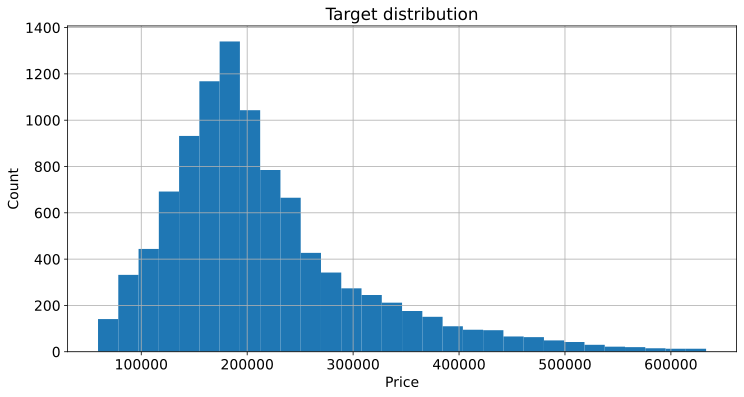

In [13]:
plt.figure(figsize = (12, 6))
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

Как видно на гистограме, распределение целевой переменной log нормальное

#### Корреляции

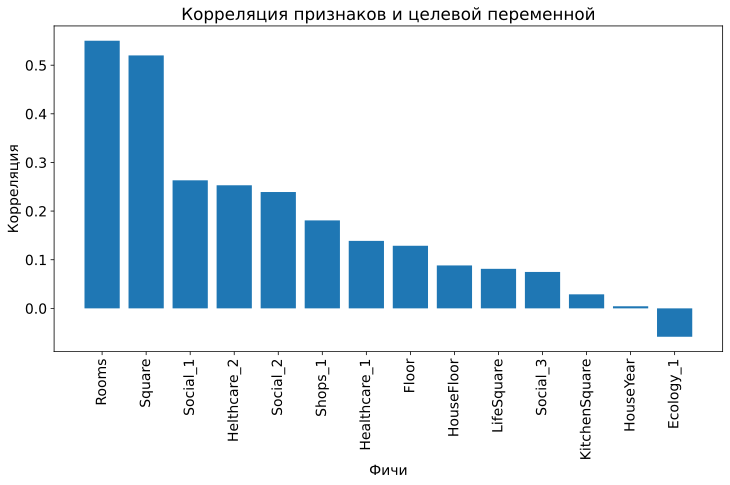

In [14]:
correlations = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlations.drop('Price', inplace=True)
plt.figure(figsize=(12,6))
plt.bar(correlations.index, correlations)
plt.xticks(rotation='90')
plt.ylabel('Корреляция')
plt.xlabel('Фичи')
plt.title('Корреляция признаков и целевой переменной')
plt.show()

Как видно на гистограме, нибольшее значение в ценообразовании имеют количество комнат и площадь квартиры.
Наименее значимыми признаками являются экологические показатели местности, год постройки дома и площадь кухни.
Данную закономерность можно проследить также и на матрице корреляций, которую мы представим ниже


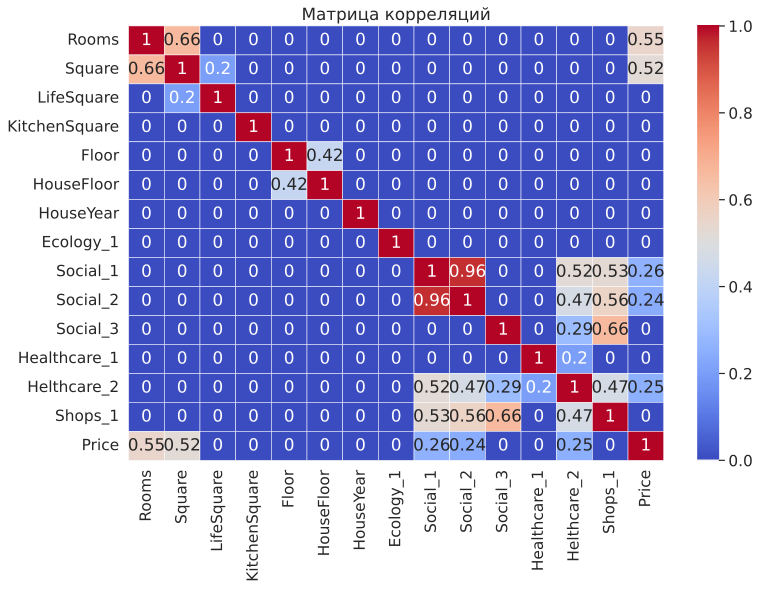

In [15]:
sns.set(font_scale=1.4)
plt.figure(figsize=(12,8))

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляций')
plt.show()

#### Количественные переменные

In [16]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Подозрительные данные или выбросы
* Максимальное количество комнат 19 - ***нужно исследовать***
* Минимальное количество комнат 0 - ***явный выброс***
* Маскимальная площадь меньше максимальной жилой площади и меньше максимальной площади кухни - ***скорее всего выброс нужно исследовать***
* Минимальная общая площадь равна 1 - ***скорее всего выброс***
* Минимальная жилая площадь меньше одного квадратного метра - ***скорее всего выброс***
* Нулевая минимальная этажность дома - ***явный выброс***
* Очень много пропусков по признаку жилой площади - ***нужно решать, что делать с пропусками***


#### Категориальные переменные

In [17]:
cat_features = train_df.select_dtypes(include='object').columns.tolist()
cat_features

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [18]:
for col in cat_features[2:]:
    print(f'{train_df.groupby([col]).agg({"Price": ["mean", "count"]})}\n{"*" * 100}\n')

                   Price      
                    mean count
Ecology_2                     
A          193139.717006    97
B          214344.544223  9903
****************************************************************************************************

                   Price      
                    mean count
Ecology_3                     
A          243179.560704   275
B          213317.654992  9725
****************************************************************************************************

                 Price      
                  mean count
Shops_2                     
A        192339.700513   825
B        216098.999571  9175
****************************************************************************************************



In [19]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  int64  
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

#### Обработка выбросов

##### Rooms

In [20]:
train_df['Rooms'].value_counts().sort_index()

0        8
1     3705
2     3880
3     2235
4      150
5       18
6        1
10       2
19       1
Name: Rooms, dtype: int64

In [21]:
train_df['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [22]:
total_max_rooms = np.quantile(train_df['Rooms'], q = 0.975)
total_max_rooms

3.0

In [23]:
total_min_rooms = np.quantile(train_df['Rooms'], q = 0.025)
total_min_rooms

1.0

Таким образом выбросами в нашем случае являются квартиры, где указано число комнат 0, 6, 10, 19.
В нашем случае таких выбросов немного и мы можем заменить эти значения модой или медианой.
Или часть выбросов заменить на 1, а часть на 2, т.к. однокомнатных квартир также достаточно.

In [24]:
def rooms(df):
    df['Rooms_outlier'] = 0
    df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
   
    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    df.loc[df['Rooms'] >= 6, 'Rooms'] = df['Rooms'].mode()[0]
    
    return

rooms(train_df)

In [25]:
train_df['Rooms'].value_counts().sort_index()

1    3713
2    3884
3    2235
4     150
5      18
Name: Rooms, dtype: int64

##### Square 	LifeSquare 	KitchenSquare 	

In [26]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,7887.000000,10000.000000
mean,56.315775,37.199645,6.273300
std,21.058732,86.241209,28.560917
min,1.136859,0.370619,0.000000
25%,41.774881,22.769832,1.000000
50%,52.513310,32.781260,6.000000
75%,65.900625,45.128803,9.000000
max,641.065193,7480.592129,2014.000000


In [27]:
(train_df['Square'] < (train_df['LifeSquare'] + train_df['KitchenSquare'])).sum()

845

Таким образом мы имеем достаточно большое количество данных,
по которым наблюдаются следующие выбросы:
* а) 845 квартир в которых общая площадь меньше суммы площадей жилых комнат и кухни
* б) квартиры с очень маленькой площадью 
* в) квартиры с очень большой площадью
* г) очень мальенькая площадь жилых помещений, меньше 10 кв.м.
* д) очень маленькая площадь кухни, меньше 3 кв. м.

Напишем функцию, которая будет заменять эти выбросы на медианы в зависимости от количества комнат

In [28]:
def square_rooms(df, nrooms):
    rooms_df = df[df['Rooms'] == nrooms]
    square_median = rooms_df['Square'].median()
    life_square_median = rooms_df['LifeSquare'].median()
    kitchen_square_median = rooms_df['KitchenSquare'].median()
    df.loc[(df['Rooms'] == nrooms) & ((df['Square'] > df['Square'].quantile(.975))\
                                    | (df['Square'] < df['Square'].quantile(.025))\
                                    | (df['Square'] < (df['LifeSquare'] + df['KitchenSquare']))), 'Square'] = square_median
    df.loc[(df['Rooms'] == nrooms) & ((df['LifeSquare'] > df['LifeSquare'].quantile(.975))\
                                    | (df['LifeSquare'] < df['LifeSquare'].quantile(.025))\
                                    | (df['Square'] < (df['LifeSquare'] + df['KitchenSquare']))), 'LifeSquare'] = life_square_median
    df.loc[(df['Rooms'] == nrooms) & ((df['KitchenSquare'] > df['KitchenSquare'].quantile(.975))\
                                    | (df['KitchenSquare'] < df['KitchenSquare'].quantile(.025))\
                                    | (df['Square'] < (df['LifeSquare'] + df['KitchenSquare']))), 'KitchenSquare'] = kitchen_square_median
    
    return

In [29]:
for el in range(1, 6):
    square_rooms(train_df, el)

In [30]:
(train_df['Square'] < (train_df['LifeSquare'] + train_df['KitchenSquare'])).sum()

0

In [31]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,7887.000000,10000.000000
mean,55.204960,33.414330,5.518300
std,15.915038,12.258044,3.641482
min,32.105270,5.927865,0.000000
25%,41.239098,22.289890,1.000000
50%,52.539538,32.035539,6.000000
75%,65.416166,42.469016,8.000000
max,116.084861,80.458910,13.000000


Остался ряд квартир с жилой площадью меньше 10 кв. м. и кухонными помещениями меньше 3 кв.м.

In [32]:
def small_square(df):
    df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = 10
    df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    
    return

small_square(train_df)

In [33]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,7887.000000,10000.000000
mean,55.204960,33.416023,6.219800
std,15.915038,12.254547,2.760951
min,32.105270,10.000000,3.000000
25%,41.239098,22.289890,3.000000
50%,52.539538,32.035539,6.000000
75%,65.416166,42.469016,8.000000
max,116.084861,80.458910,13.000000


### HouseFloor, Floor

In [34]:
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117])

In [35]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [36]:
def hous_floor(df):
    df.loc[df['HouseFloor'] < 2, 'HouseFloor'] = int(df['HouseFloor'].median())
    np.random.seed(27)
    floor_outliers = df[df['Floor'] > df['HouseFloor']].index
#     print(len(floor_outliers))
    df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(
        lambda x: random.randint(1, x)
    )
    
    return

hous_floor(train_df)

### HouseYear

In [37]:
train_df['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [38]:
def house_year(df):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
    
house_year(train_df)

### Обработка пропусков

In [39]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Rooms_outlier       0
dtype: int64

In [40]:
def omissions(df):
    df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1

    condition = (df['LifeSquare'].isna()) \
                 & (~df['Square'].isna()) \
                 & (~df['KitchenSquare'].isna())
        
    df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] \
                                            - df.loc[condition, 'KitchenSquare'] - 5
    
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    
    return

omissions(train_df)

In [41]:
train_df.isna().sum()

Id                0
DistrictId        0
Rooms             0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Ecology_2         0
Ecology_3         0
Social_1          0
Social_2          0
Social_3          0
Healthcare_1      0
Helthcare_2       0
Shops_1           0
Shops_2           0
Price             0
Rooms_outlier     0
LifeSquare_nan    0
dtype: int64

In [42]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,LifeSquare_nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,55.204960,36.985702,6.219800,7.683100,13.555500,1984.872400,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.001200,0.211300
std,0.811438,15.915038,14.790302,2.760951,4.888094,5.835557,18.416347,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.034622,0.408251
min,1.000000,32.105270,10.000000,3.000000,1.000000,2.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000
25%,1.000000,41.239098,23.849509,3.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,0.000000,0.000000
50%,2.000000,52.539538,33.314948,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000
75%,2.000000,65.416166,46.872982,8.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,0.000000,0.000000
max,5.000000,116.084861,108.084861,13.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000


#### Построение новых признаков

In [43]:
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']].head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [44]:
def new_features(df):
    littera = {'A':0, 'B':1}
    df['Ecology_2_bin'] = df['Ecology_2'].replace(littera)
    df['Ecology_3_bin'] = df['Ecology_3'].replace(littera)
    df['Shops_2_bin'] = df['Shops_2'].replace(littera)
    
    return

new_features(train_df)

#### DistrictSize, IsDistrictLarge

In [45]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [46]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,11809,27,3,77.413643,62.413643,10.0,4,10,2014,0.075424,...,0,0,B,305018.871089,0,1,1,1,1,851
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,1,0,B,177734.553407,0,0,1,1,1,78
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,3,1,B,282078.720850,0,0,1,1,1,652
3,2352,1,1,40.409907,32.409907,3.0,10,22,1977,0.007122,...,0,1,B,168106.007630,0,1,1,1,1,652
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,0,6,B,343995.102962,0,0,1,1,1,89


In [47]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### MedPriceByDistrict

In [48]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1,142799.434052
1,0,2,176210.812334
2,0,3,300610.359425
3,1,1,146735.671740
4,1,2,202666.310126


In [49]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,LifeSquare_nan,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3,77.413643,62.413643,10.0,4,10,2014,0.075424,...,B,305018.871089,0,1,1,1,1,851,1,213530.788443
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,B,177734.553407,0,0,1,1,1,78,0,146032.829834
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,B,282078.720850,0,0,1,1,1,652,1,244005.272380
3,2352,1,1,40.409907,32.409907,3.0,10,22,1977,0.007122,...,B,168106.007630,0,1,1,1,1,652,1,146735.671740
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,B,343995.102962,0,0,1,1,1,89,0,201584.441255


### Отбор признаков

In [50]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'LifeSquare_nan',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [51]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict', 'Rooms_outlier']

target_name = 'Price'

In [52]:
train_df.shape

(10000, 28)

In [53]:
test_df.shape

(5000, 19)

### Разбиение на train и test

In [54]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.29, shuffle=True, random_state=20
)

### Построение модели

In [56]:
rf_model = RandomForestRegressor(
    max_depth=8, min_samples_split=100, n_estimators=500, n_jobs=-1, random_state=39
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500,
                      n_jobs=-1, random_state=39)

Train R2:	0.754
Valid R2:	0.722


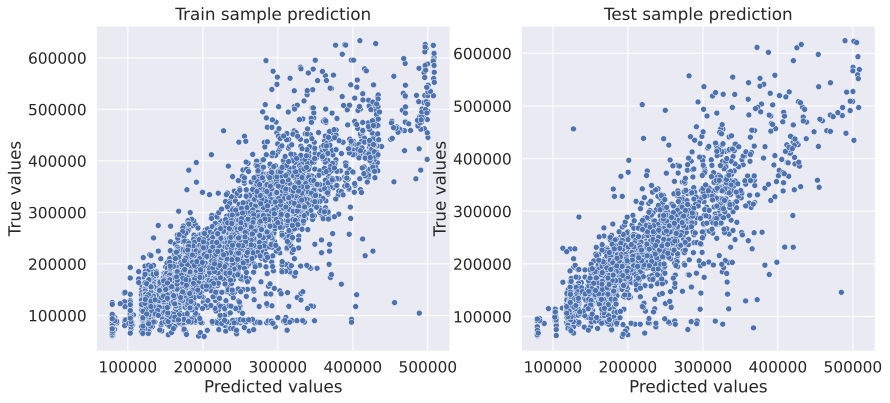

In [57]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Перенос признаков

In [58]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [59]:
data_types(test_df)

In [60]:
rooms(test_df)

In [61]:
for el in range(1, 6):
    square_rooms(test_df, el)

In [62]:
small_square(test_df)

In [63]:
hous_floor(test_df)

In [64]:
house_year(test_df)

In [65]:
omissions(test_df)

In [66]:
new_features(test_df)

In [67]:
district_size = test_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

In [68]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [69]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   object 
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   int64  
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   int64  
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

In [70]:
test_df.loc[test_df['MedPriceByDistrict'].isna(), 'MedPriceByDistrict'] = test_df['MedPriceByDistrict'].median()

In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   object 
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   int64  
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   int64  
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

In [72]:
test_df_ = test_df[feature_names + new_feature_names]

### Формирование файла с предсказаниями

In [73]:
predictions = rf_model.predict(test_df_)
predictions

array([159765.98828004, 128101.005923  , 163537.09284864, ...,
       148862.35638019, 175944.1451534 , 236903.45095277])

In [74]:
pred_df = pd.DataFrame()
pred_df['Id'] = test_df['Id']
pred_df['Price'] = predictions
pred_df.head()

,Id,Price
0,4567,159765.988280
1,5925,128101.005923
2,960,163537.092849
3,3848,153508.829947
4,746,174380.438476


In [75]:
pred_df.to_csv('predictions.csv', index=0)